In [22]:
import requests
import re
import json
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import multidict
from wordcloud import WordCloud

In [13]:
def replaceUrlToEmpty(content) :
    urlList = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', content) 
    for url in urlList:
        content = content.replace(url, "")
    return content
def crawl_article(url):
    response = requests.get(url, cookies={'over18': '1'})
    
    # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(url))
        return
    
    # 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
    soup = BeautifulSoup(response.text)
    
    # 取得文章內容主體
    main_content = soup.find(id='main-content')
    
    # 假如文章有屬性資料 (meta), 我們在從屬性的區塊中爬出作者 (author), 文章標題 (title), 發文日期 (date)
    metas = main_content.select('div.article-metaline')
    author = ''
    title = ''
    date = ''
    if metas:
        if metas[0].select('span.article-meta-value')[0]:
            author = metas[0].select('span.article-meta-value')[0].string
        if metas[1].select('span.article-meta-value')[0]:
            title = metas[1].select('span.article-meta-value')[0].string
        if metas[2].select('span.article-meta-value')[0]:
            date = metas[2].select('span.article-meta-value')[0].string

        # 從 main_content 中移除 meta 資訊（author, title, date 與其他看板資訊）
        #
        # .extract() 方法可以參考官方文件
        #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#extract
        for m in metas:
            m.extract()
        for m in main_content.select('div.article-metaline-right'):
            m.extract()
    
    # 取得留言區主體
    pushes = main_content.find_all('div', class_='push')
    for p in pushes:
        p.extract()
    
    # 假如文章中有包含「※ 發信站: 批踢踢實業坊(ptt.cc), 來自: xxx.xxx.xxx.xxx」的樣式
    # 透過 regular expression 取得 IP
    # 因為字串中包含特殊符號跟中文, 這邊建議使用 unicode 的型式 u'...'
    try:
        ip = main_content.find(text=re.compile(u'※ 發信站:'))
        ip = re.search('[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*', ip).group()
    except Exception as e:
        ip = ''
    
    # 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
    # 保留英數字, 中文及中文標點, 網址, 部分特殊符號
    #
    # 透過 .stripped_strings 的方式可以快速移除多餘空白並取出文字, 可參考官方文件 
    #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings
    filtered = []
    for v in main_content.stripped_strings:
        # 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
        if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
            filtered.append(v)

    # 定義一些特殊符號與全形符號的過濾器
    expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
    for i in range(len(filtered)):
        filtered[i] = re.sub(expr, '', filtered[i])
    
    # 移除空白字串, 組合過濾後的文字即為文章本文 (content)
    filtered = [i for i in filtered if i]
    content = ' '.join(filtered)
    content = replaceUrlToEmpty(content)
    # 處理留言區
    # p 計算推文數量
    # b 計算噓文數量
    # n 計算箭頭數量
    p, b, n = 0, 0, 0
    messages = []
    for push in pushes:
        # 假如留言段落沒有 push-tag 就跳過
        if not push.find('span', 'push-tag'):
            continue
        
        # 過濾額外空白與換行符號
        # push_tag 判斷是推文, 箭頭還是噓文
        # push_userid 判斷留言的人是誰
        # push_content 判斷留言內容
        # push_ipdatetime 判斷留言日期時間
        push_tag = push.find('span', 'push-tag').string.strip(' \t\n\r')
        push_userid = push.find('span', 'push-userid').string.strip(' \t\n\r')
        push_content = push.find('span', 'push-content').strings
        push_content = ' '.join(push_content)[1:].strip(' \t\n\r')
        push_ipdatetime = push.find('span', 'push-ipdatetime').string.strip(' \t\n\r')
        
        # 整理打包留言的資訊, 並統計推噓文數量
        messages.append({
            'push_tag': push_tag,
            'push_userid': push_userid,
            'push_content': push_content,
            'push_ipdatetime': push_ipdatetime})
        if push_tag == u'推':
            p += 1
        elif push_tag == u'噓':
            b += 1
        else:
            n += 1
    
    # 統計推噓文
    # count 為推噓文相抵看這篇文章推文還是噓文比較多
    # all 為總共留言數量 
    message_count = {'all': p+b+n, 'count': p-b, 'push': p, 'boo': b, 'neutral': n}
    
    # 整理文章資訊
    data = {
        'url': url,
        'article_author': author,
        'article_title': title,
        'article_date': date,
        'article_content': content,
        'ip': ip,
        'message_count': message_count,
        'messages': messages
    }
    return data

In [ ]:
def getPTThtmlPage(all_data, page):
    url = 'https://www.ptt.cc/bbs/HatePolitics/index{}.html'.format(page)
    response = requests.get(url, cookies = {'over18':'1'})
    # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(url))
        return
    
    soup = BeautifulSoup(response.text)
    main_list = soup.find('div', class_='bbs-screen')

    # 依序檢查文章列表中的 tag, 遇到分隔線就結束, 忽略這之後的文章
    for div in main_list.findChildren('div', recursive=False):
        class_name = div.attrs['class']
    
        # 遇到分隔線要處理的情況
        if class_name and 'r-list-sep' in class_name:
            print('Reach the last article')
            break
        # 遇到目標文章
        if class_name and 'r-ent' in class_name:
            div_title = div.find('div', class_='title')
            a_title = div_title.find('a', href=True)
            if a_title is None:
                continue
            article_URL = urljoin(url, a_title['href'])
            article_title = a_title.text
            print('Parse {} - {}'.format(article_title, article_URL))

            # 呼叫上面寫好的 function 來對文章進行爬蟲
            try:
                parse_data = crawl_article(article_URL)
            except:
                continue
            # 將爬完的資料儲存
            all_data.append(parse_data)

In [ ]:
result = []
for page in range(2757, 3320, 1):
    result.append(getPTThtmlPage(result, page))
len(result)

In [ ]:
# 存取資料
import json
json = json.dumps(result)
f = open("ptt_2757_3320.json","w")
f.write(json)
f.close()
len(result)

In [ ]:
import jieba
import jieba.analyse
# https://github.com/fxsjy/jieba
## 關鍵詞分析自建字典
for content in result:
    if  content is not None:
        for word in jieba.analyse.extract_tags(content['article_content'], topK=30, withWeight=False, allowPOS=()):
            if (word is not '\n') or (re.match('[.;?$%&@]', word) is not None):
                jieba.add_word(word)
        for word in jieba.analyse.extract_tags(content['article_content'], topK=30, withWeight=False, allowPOS=()):
            if (word is not '\n') or (re.match('[.;?$%&@]', word) is not None):
                jieba.add_word(word)        

jieba.add_word('蔡英文')
jieba.add_word('小英')
jieba.add_word('柯文哲')
jieba.add_word('韓國瑜')
jieba.add_word('國民黨')
jieba.add_word('民進黨')
jieba.add_word('民眾黨')
jieba.add_word('時代力量')
print('Build Own Direction Success.')

In [ ]:
### 文章切詞
import jieba
import jieba.posseg as pseg
from snownlp import SnowNLP
cut_data = []
for content in result:
    if  content is not None:
        single_cut_data = []
        # 情緒分析
        if content['article_content'] == '':
            continue
        emo_sensitive = SnowNLP(content['article_content'])
        content['emo_sensitive'] = emo_sensitive.sentiments
        # 詞語分析
        for word, flag in pseg.cut(content['article_content']):
#       不是c连词,u助词,xc其他虚词,w标点符号, m数量词, d副詞
            if flag not in ['x', 'uj', 'c', 'xc', 'w', 'm', 'd']:
                cut_data.append(word)
                single_cut_data.append(word)
        for push in content['messages']:    
            for word, flag in pseg.cut(push['push_content']):
                if flag not in ['x', 'uj', 'c', 'xc', 'w', 'm', 'd']:
                    cut_data.append(word)
                    single_cut_data.append(word)
        content['cut_data'] = single_cut_data
        
print('Cut content success.')

In [16]:
def getFrequcyData(cut_data):
    duplicate = []
    frequency_data = []
    for data in cut_data:
        if data not in duplicate:
            frequency_data.append([data, cut_data.count(data)])
            duplicate.append(data)
    return pd.DataFrame(frequency_data, columns=['word', 'count']).sort_values('count', ascending = False)

def drawWordCloud(tsai_freqency_data, result):
    tsai_result = tsai_freqency_data.loc[tsai_freqency_data.word.str.len()>1].loc[tsai_freqency_data['count'] > 10]
    output_special = tsai_freqency_data.loc[tsai_freqency_data.word.isin(['柯', '韓', '蔡', '蘇'])]
    output = tsai_result.append(output_special).sort_values('count', ascending = False)
    print('---------Frequency Data----------')
    print(output.head(30))
    stopwords = ['不要', '自己', 'https', 'com', 'imgur', 'jpg', '知道', '可能', '大家']
    tmpDict = multidict.MultiDict()
    for key in output.index:
        if output['word'][key] not in stopwords:
            tmpDict.add(output['word'][key], output['count'][key])
    wc = WordCloud(stopwords=stopwords, font_path="msjh.ttc", background_color="#ECEFEF", max_words=100, min_font_size=16,
               max_font_size=100, random_state=42, width=500, height=460, margin=2,)
    my_wordcloud = wc.generate_from_frequencies(tmpDict)
    print('---------Word Cloud----------')
    plt.imshow(my_wordcloud)
    plt.axis("off")
    plt.show()


In [24]:
# 蔡英文相關分析
tsai_cut_data = []
for content in result:
    if content is not None:
        if ("蔡" in content['cut_data']) or ("英文" in content['cut_data']):
            tsai_cut_data.extend(content['cut_data'])
            
tsai_freqency_data = getFrequcyData(tsai_cut_data)

---------Frequency Data----------
       word  count
579       柯    322
57        蔡    289
616      柯文    238
58       英文    217
322      自己    197
315      知道    168
335      不要    121
736      蟑螂    115
187      政治    105
775      看到    103
64       根本     83
386      支持     82
838   https     82
12       可能     74
1015    com     73
256      而已     71
28       政府     67
712       韓     66
0        肺炎     65
267      合作     65
1014  imgur     64
1017    jpg     59
210      大家     56
892      行政     53
864      台北     52
29       代表     51
131      中共     49
415      不用     48
400      有人     46
1006     香港     44
---------Word Cloud----------


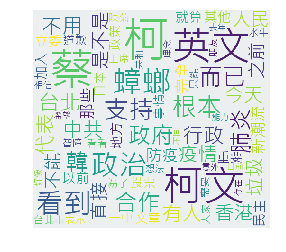

---------Frequency Data----------
N    0.814815
P    0.185185
dtype: float64


In [25]:
drawWordCloud(tsai_freqency_data, result)

In [26]:
sensitive = []
for content in result:
    if content is not None:
        if ("蔡" in content['cut_data']) or ("英文" in content['cut_data']):
            sensitive.append(content['emo_sensitive'])
summary = pd.Series(['P' if i > 0.5 else 'N' for i in sensitive]).value_counts()
print(summary/sum(summary))